In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import os
import shutil
import json

# --- Configuration ---

# 1. Path to your Kaggle data
# !! IMPORTANT !!
# I updated this path based on your screenshot
ZIP_FILE_PATH = '/kaggle/input/isl-project/archive (1).zip' 

# 2. Path to save your finished model (Kaggle's working directory)
MODEL_SAVE_DIR = '/kaggle/working/MyMobileNetModel'

# 3. Path to unzip to (Kaggle's temporary disk)
LOCAL_DATA_DIR = '/kaggle/working/dataset' 

# 4. Model Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 15

print("Configuration set.")

2025-11-06 16:42:17.802130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762447337.999077      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762447338.050763      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Configuration set.


In [2]:
# Run this to see the real file name
!ls /kaggle/input/isl-project/

images


In [3]:
# !! IMPORTANT !!
# We are pointing directly to the 'images' folder you found
DATA_DIR = "/kaggle/input/isl-project/images" 

print(f"Loading data from: {DATA_DIR}")

# --- Load Training Data (80%) ---
try:
    train_dataset = image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )

    # --- Load Validation Data (20%) ---
    validation_dataset = image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
except tf.errors.NotFoundError:
    print(f"--- !! ERROR !! ---")
    print(f"Could not find the directory: {DATA_DIR}")
    print("Please double-check the 'isl-project' and 'images' folder names in your Kaggle Input sidebar.")
    # This error shouldn't happen if the path is correct
    raise


# Get class names and count
class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print(f"\nFound {NUM_CLASSES} classes: {class_names}")

# --- Apply MobileNet's specific preprocessing ---
def preprocess_for_mobilenet(image, label):
    image = preprocess_input(image)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_for_mobilenet).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_for_mobilenet).prefetch(buffer_size=AUTOTUNE)

print("\nSUCCESS: Data is loaded and preprocessed for MobileNet.")

Loading data from: /kaggle/input/isl-project/images
Found 196621 files belonging to 110 classes.
Using 157297 files for training.


I0000 00:00:1762447424.818231      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762447424.818969      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 196621 files belonging to 110 classes.
Using 39324 files for validation.

Found 110 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'All_Gone', 'Alone', 'Baby', 'Beside', 'Book', 'Bowl', 'Bridge', 'Call', 'Camp', 'Cartridge', 'Flower', 'Fond', 'Glove', 'H', 'Hang', 'High', 'House', 'How_Many', 'I want Food', 'I_m Good', 'IorMe', 'J', 'Man', 'Marry', 'Meat', 'Medal', 'Mid_Day', 'Middle', 'Money', 'Moon', 'Mother', 'Opposite', 'Pain', 'Prisoner', 'Ring', 'Rose', 'See', 'Short', 'Stop', 'Superior', 'Theif', 'There is Gun', 'Thick', 'Thin', 'Tobacco', 'Up', 'V', 'Victory', 'Watch', 'Write', 'a', 'aboard', 'afraid', 'agree', 'assistance', 'b', 'bad', 'become', 'c', 'college', 'd', 'del', 'doctor', 'e', 'f', 'friend', 'from', 'g', 'i', 'k', 'l', 'm', 'n', 'not fine', 'nothing', 'o', 'ok fine', 'p', 'pray', 'q', 'r', 's', 'secondary', 'skin', 'small', 'space', 'specific', 'stand', 't', 'today', 'u', 'unknown', 'w', 'warn', 'which', 'work', 'x', 'y', 'you', 'z']

SUCCESS: Dat

In [4]:
def build_mobilenet_model(input_shape, num_classes):
    """Loads MobileNetV2, freezes it, and adds a new head."""
    
    # 1. Load the pre-trained MobileNetV2
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')

    # 2. Freeze the base model
    base_model.trainable = False

    # 3. Add our new "head"
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # 4. Create the new model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- Build the model ---
print("\nBuilding the MobileNetV2 model...")
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
model = build_mobilenet_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()


Building the MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,614,190 (9.97 MB)

 Trainable params: 356,206 (1.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# --- 1. Checkpoint Setup ---
checkpoint_path = os.path.join(MODEL_SAVE_DIR, "best_model.h5")
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, # This is the most important part
    verbose=1
)

# --- 2. Plotting Function (Safe Version) ---
def plot_training_history(history):
    """Plots the accuracy and loss from the training history."""
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('validation_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('validation_loss', [])
    
    if not acc or not val_acc:
        print("\nPlotting error: Could not find 'val_accuracy' in history.")
        print(f"Keys found: {history.history.keys()}")
        return

    epochs_range = range(len(acc))
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# --- 3. Start Training ---
print(f"\n--- Starting Model Training for {EPOCHS} Epochs ---")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

print("\n--- Training Complete ---")
print(f"Your 'best_model.h5' is saved in {MODEL_SAVE_DIR}")

# --- 4. Plot Results Immediately ---
print("\n--- Plotting Results ---")
plot_training_history(history)

# --- 5. Save the Final Epoch Model (as a backup) ---
final_model_path = os.path.join(MODEL_SAVE_DIR, 'final_epoch_model.h5')
model.save(final_model_path)
print(f"Final epoch model saved to {final_model_path}")


--- Starting Model Training for 15 Epochs ---
Epoch 1/15


I0000 00:00:1762447462.967344      68 service.cc:148] XLA service 0x7a80d0002be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762447462.967988      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762447462.968009      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762447463.874337      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


  11/4916 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.0225 - loss: 5.2083 

I0000 00:00:1762447467.728704      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4916/4916 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6592 - loss: 1.2662
Epoch 1: val_accuracy improved from -inf to 0.96501, saving model to /kaggle/working/MyMobileNetModel/best_model.h5
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 228s 44ms/step - accuracy: 0.6592 - loss: 1.2661 - val_accuracy: 0.9650 - val_loss: 0.1173
Epoch 2/15
4912/4916 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9026 - loss: 0.2975
Epoch 2: val_accuracy improved from 0.96501 to 0.97505, saving model to /kaggle/working/MyMobileNetModel/best_model.h5
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.9026 - loss: 0.2975 - val_accuracy: 0.9751 - val_loss: 0.0793
Epoch 3/15
4914/4916 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9250 - loss: 0.2287
Epoch 3: val_accuracy improved from 0.97505 to 0.98139, saving model to /kaggle/working/MyMobileNetModel/best_model.h5
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.9250 - loss: 0.2287 - val_accuracy: 0.9814 - val_loss: 0.0603
Epoch 4/15
4914/4916 ━━━━━


--- Plotting Results (Corrected) ---


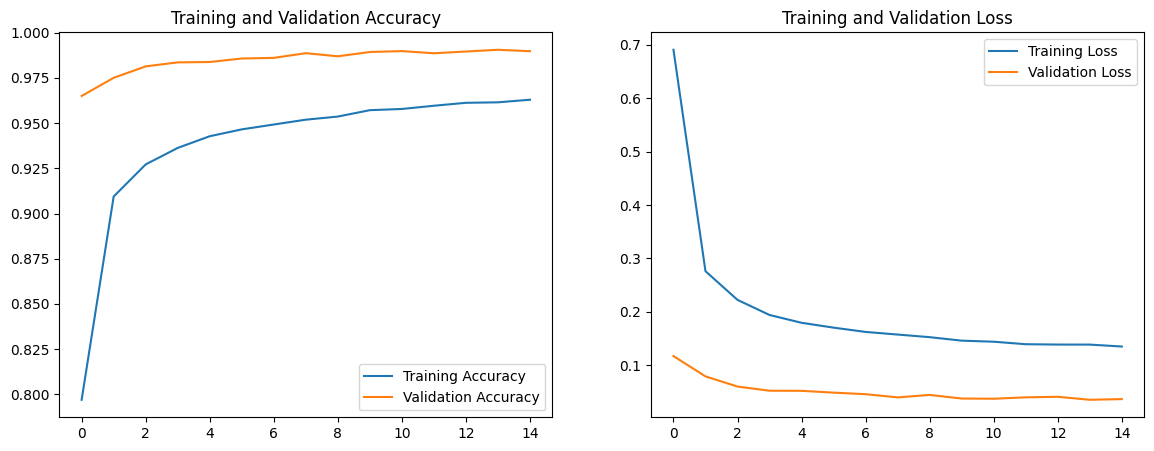

In [6]:
import matplotlib.pyplot as plt

# --- 1. Define the Plotting Function (Corrected) ---
def plot_training_history_corrected(history_obj):
    """Plots the accuracy and loss from the training history."""
    
    # --- FIXED THE TYPOS ---
    # It's 'val_accuracy', not 'validation_accuracy'
    acc = history_obj.history.get('accuracy', [])
    val_acc = history_obj.history.get('val_accuracy', []) 
    loss = history_obj.history.get('loss', [])
    val_loss = history_obj.history.get('val_loss', [])
    
    if not acc or not val_acc:
        print("\nPlotting error: Could not find accuracy keys in history.")
        print(f"Keys found: {history_obj.history.keys()}")
        return

    epochs_range = range(len(acc))
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# --- 2. Plot Results ---
# 'history' is already in your notebook's memory from the last cell
print("\n--- Plotting Results (Corrected) ---")
plot_training_history_corrected(history)

In [7]:
# --- Save the labels ---
labels_path = os.path.join(MODEL_SAVE_DIR, 'labels.json')

if 'class_names' in locals():
    with open(labels_path, 'w') as f:
        json.dump(class_names, f)
    print(f"Labels saved successfully to: {labels_path}")
    print("\n--- YOU ARE DONE! ---")
    print("You can now go to the 'Output' section in the sidebar,")
    print(f"navigate to {MODEL_SAVE_DIR}, and download:")
    print("1. best_model.h5")
    print("2. labels.json")
else:
    print("Error: 'class_names' not found. Please re-run Cell 3 to generate it.")

Labels saved successfully to: /kaggle/working/MyMobileNetModel/labels.json

--- YOU ARE DONE! ---
You can now go to the 'Output' section in the sidebar,
navigate to /kaggle/working/MyMobileNetModel, and download:
1. best_model.h5
2. labels.json
